In [8]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import random

# Loading In the Datasets

In [9]:
# Read Data from Human Sequences
with open("all_ssRNA(+_-).fasta") as file:
    fasta_sequences = SeqIO.parse(file, 'fasta')


    records = []

    for fasta in fasta_sequences:
        description = fasta.description.split("|")
        if len(description) >= 3:
            species = description[2].strip()
        else:
            species = "Unknown"

        name = fasta.id
        sequence = str(fasta.seq)

        # Filter out sequences with no known bases
        if "N" in sequence:
            continue

        records.append({
            'id': name,
            'sequence': sequence,
            'Y': species,
            'sequence_len': len(sequence)
        })

df = pd.DataFrame(records)
df.head()

,id,sequence,Y,sequence_len
0,NC_086348.1,ACACAAAGGCGCCCAATCATGGATGACATAATATCAAAACAAGTTG...,Lutzomyia,6374
1,NC_086346.1,ACACAAAGTTACCTAAACTTTGTGTTTGAGTCCTGAAATACAAACA...,Lutzomyia,1863
2,NC_086347.1,CTTTGTGTTTGACGGTGTTAATGAATTCAAAAAACATTTTTTATCT...,Lutzomyia,4310
3,NC_077806.1,CGCACCGGGGATCCTAGGCGTTTAGTTGCGCTGTTTGGTTGCACAA...,,7228
4,NC_077807.1,CGCACCGGGGATCCTAGGCTTTTTGGATTGCGCTTTCCTCTAGATC...,,3376


In [3]:
len(df)

26847

In [4]:
(df['Y'] == "").sum()

3276

In [10]:
# remove rows that don't have any species info
df = df[df['Y'] != '']
df.head()

,id,sequence,Y,sequence_len
0,NC_086348.1,ACACAAAGGCGCCCAATCATGGATGACATAATATCAAAACAAGTTG...,Lutzomyia,6374
1,NC_086346.1,ACACAAAGTTACCTAAACTTTGTGTTTGAGTCCTGAAATACAAACA...,Lutzomyia,1863
2,NC_086347.1,CTTTGTGTTTGACGGTGTTAATGAATTCAAAAAACATTTTTTATCT...,Lutzomyia,4310
5,NC_077825.1,AGAGCAATCGAGCAACAAAATTAAAGAAAATGAACATTCAAACTAT...,Lilium,8911
7,NC_077827.1,AGAGCAATCGGTGCACCAATTCAAGAATATCATCTCTAAATCAATC...,Lilium,4704


In [6]:
(df['Y'] == "").sum()

0

# EDA

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# Print basic dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23571 entries, 0 to 26709
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            23571 non-null  object
 1   sequence      23571 non-null  object
 2   Y             23571 non-null  object
 3   sequence_len  23571 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 920.7+ KB


In [9]:
# Confirm that each ID is unique in df
print("Unique IDs:", df['id'].nunique())

Unique IDs: 23571


### Sequence Length Filtering

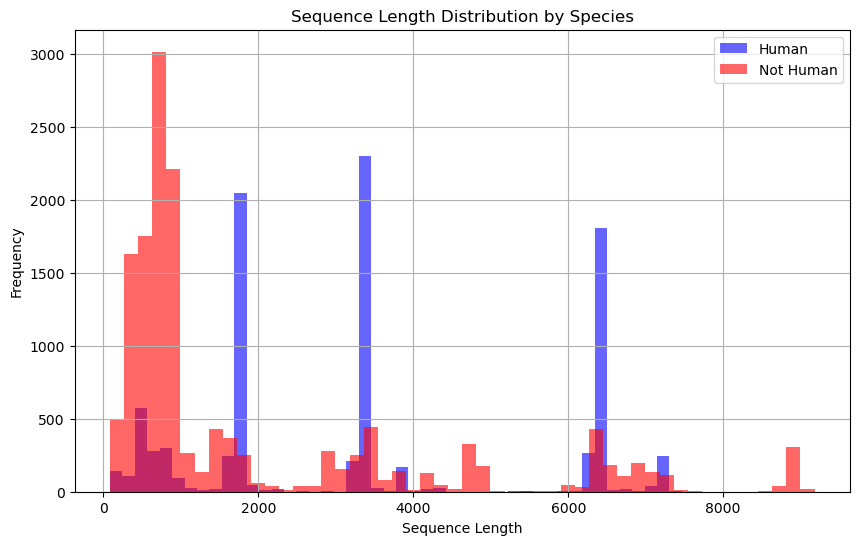

In [12]:
plt.figure(figsize=(10, 6))

# Separate DataFrames
human_seqs = df[df['Y'] == 'Homo sapiens']['sequence_len']
nonhuman_seqs = df[df['Y'] != 'Homo sapiens']['sequence_len']

plt.hist(human_seqs, bins=50, alpha=0.6, label='Human', color="b")
plt.hist(nonhuman_seqs, bins=50, alpha=0.6, label='Not Human', color="r")

plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Sequence Length Distribution by Species')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Remove Outlier Sequence Lengths
Q1 = df['sequence_len'].quantile(0.25)
Q3 = df['sequence_len'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_no_outliers = df[(df['sequence_len'] >= lower_bound) & (df['sequence_len'] <= upper_bound)]

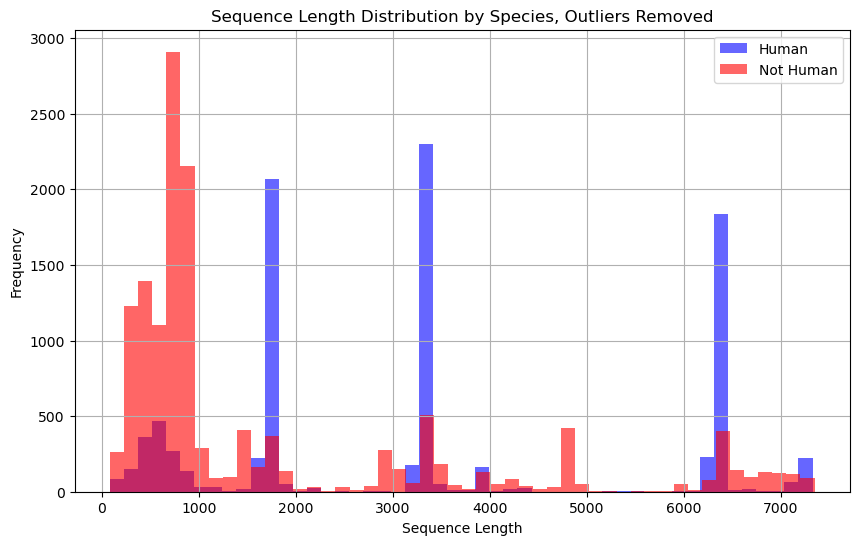

In [18]:
plt.figure(figsize=(10, 6))

# Separate DataFrames
human_seqs = df_no_outliers[df_no_outliers['Y'] == 'Homo sapiens']['sequence_len']
nonhuman_seqs = df_no_outliers[df_no_outliers['Y'] != 'Homo sapiens']['sequence_len']

plt.hist(human_seqs, bins=50, alpha=0.6, label='Human', color="b")
plt.hist(nonhuman_seqs, bins=50, alpha=0.6, label='Not Human', color="r")

plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Sequence Length Distribution by Species, Outliers Removed')
plt.legend()
plt.grid(True)
plt.show()

### Species Filtering - For Binary Classification (Human vs. NonHuman)

In [19]:
# Create a Human vs. Not Human df
df_binary = df_no_outliers.copy()

df_binary['y'] = df_binary['Y'].apply(lambda species: 'Human' if species == 'Homo sapiens' else 'Non-Human')
df_binary['y'].value_counts()

y
Non-Human    14067
Human         9112
Name: count, dtype: int64

In [20]:
human_df = df_binary[df_binary['y'] == 'Human']
nonhuman_df = df_binary[df_binary['y'] == 'Non-Human']

nonhuman_sampled = nonhuman_df.sample(9112, replace=False, random_state=42)

bal_binary_df = pd.concat([human_df, nonhuman_sampled]).reset_index(drop=True)
bal_binary_df.drop(columns="Y", inplace=True)
bal_binary_df.head()

,id,sequence,sequence_len,y
0,NC_078062.1,TTACACAAAGAACCCCTTGAATTATCAAAACATGTCCTTGTCTAAA...,1753,Human
1,NC_078063.1,AAGTAGAGGTAAACCGTAATCCACTGAGATGATTGTCCCGATTGTC...,3403,Human
2,NC_078064.1,GACGTCCAGATGAATTTAGAAGCTCTTTGCTCTAGAGTGCTTTCAG...,6356,Human
3,NC_078071.1,ATGATGTTTACACATTTAGATGTTTTAACAAGGGCAATGCTCGTAA...,4352,Human
4,NC_078072.1,ACACAAAGAAGTCCCAATAACAATGGAATCTTTACTAAGAAAGCAA...,6352,Human


In [21]:
bal_binary_df['y'].value_counts()

y
Human        9112
Non-Human    9112
Name: count, dtype: int64

### Species Filtering - For Multispecies Classification

In [22]:
# Count number of all species
df['Y'].value_counts()

Y
Homo sapiens            9113
Mastomys natalensis     1255
Arachis hypogaea        1239
Solanum lycopersicum    1191
Capsicum                 870
                        ... 
Gypsophila elegans         1
Erigeron                   1
Amaranthus hybridus        1
Eleusine indica            1
Stokesia                   1
Name: count, Length: 677, dtype: int64

/tmp/ipykernel_19835/2561457652.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


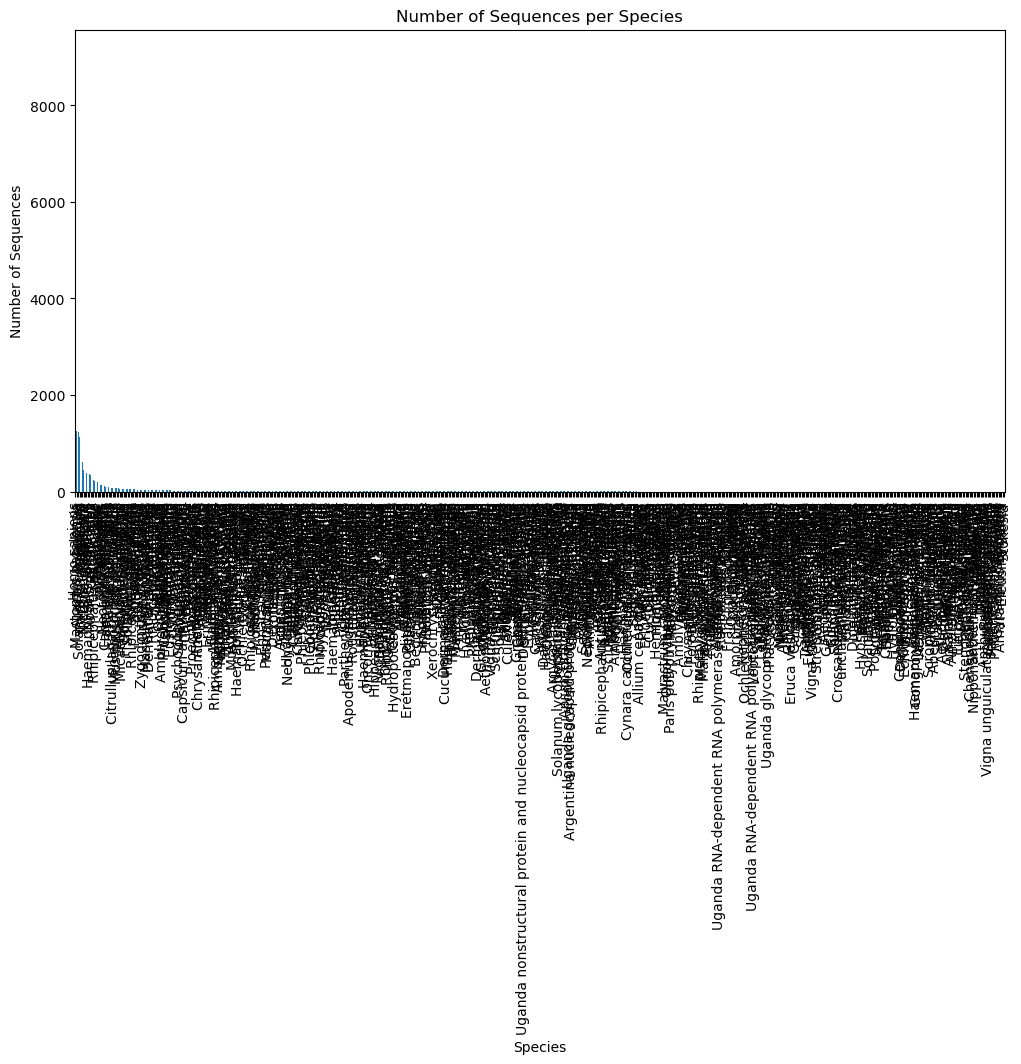

In [23]:
# Count how many sequences per species
species_counts = df_no_outliers['Y'].value_counts()

# Plot it
plt.figure(figsize=(12, 6))
species_counts.plot(kind='bar')
plt.xlabel('Species')
plt.ylabel('Number of Sequences')
plt.title('Number of Sequences per Species')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Clearly, there are a LOT of species in this data. Filtering out outliers.

In [24]:
species_counts = df_no_outliers['Y'].value_counts()

threshold = 400

# Get species that meet the threshold
valid_species = species_counts[species_counts >= threshold].index

# Filter the DataFrame to keep only these species
df_species = df_no_outliers[df_no_outliers['Y'].isin(valid_species)].reset_index(drop=True)
df_species['Y'].value_counts()

Y
Homo sapiens            9112
Mastomys natalensis     1255
Arachis hypogaea        1231
Solanum lycopersicum    1125
Capsicum                 864
Capsicum annuum          606
Diptera                  440
Nicotiana tabacum        423
Name: count, dtype: int64

In [25]:
target_samples_per_species = 423

# Create an empty list to collect balanced samples
balanced_records = []

# Loop through each species and sample
for species in df_species['Y'].unique():
    species_subset = df_species[df_species['Y'] == species]

    # If species has too much data, sample without replacement
    if len(species_subset) >= target_samples_per_species:
        sampled = species_subset.sample(n=target_samples_per_species,
                                        replace=False,
                                        random_state=42)
    else:
        sampled = species_subset

    balanced_records.append(sampled)

# Combine back into a single DataFrame
balanced_df = pd.concat(balanced_records).reset_index(drop=True)

# Check new shape
print(balanced_df['Y'].value_counts())

Y
Homo sapiens            423
Diptera                 423
Mastomys natalensis     423
Solanum lycopersicum    423
Capsicum                423
Arachis hypogaea        423
Capsicum annuum         423
Nicotiana tabacum       423
Name: count, dtype: int64


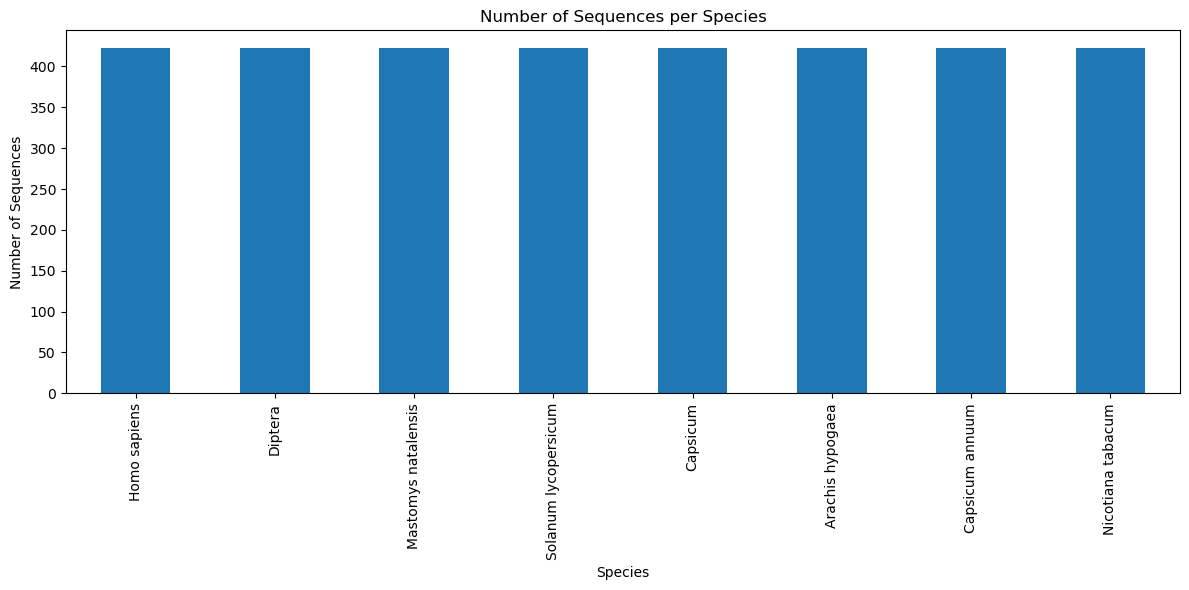

In [26]:
# Count how many sequences per species
species_counts = balanced_df['Y'].value_counts()

# Plot it
plt.figure(figsize=(12, 6))
species_counts.plot(kind='bar')
plt.xlabel('Species')
plt.ylabel('Number of Sequences')
plt.title('Number of Sequences per Species')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Balancing dataset looks like it went well!

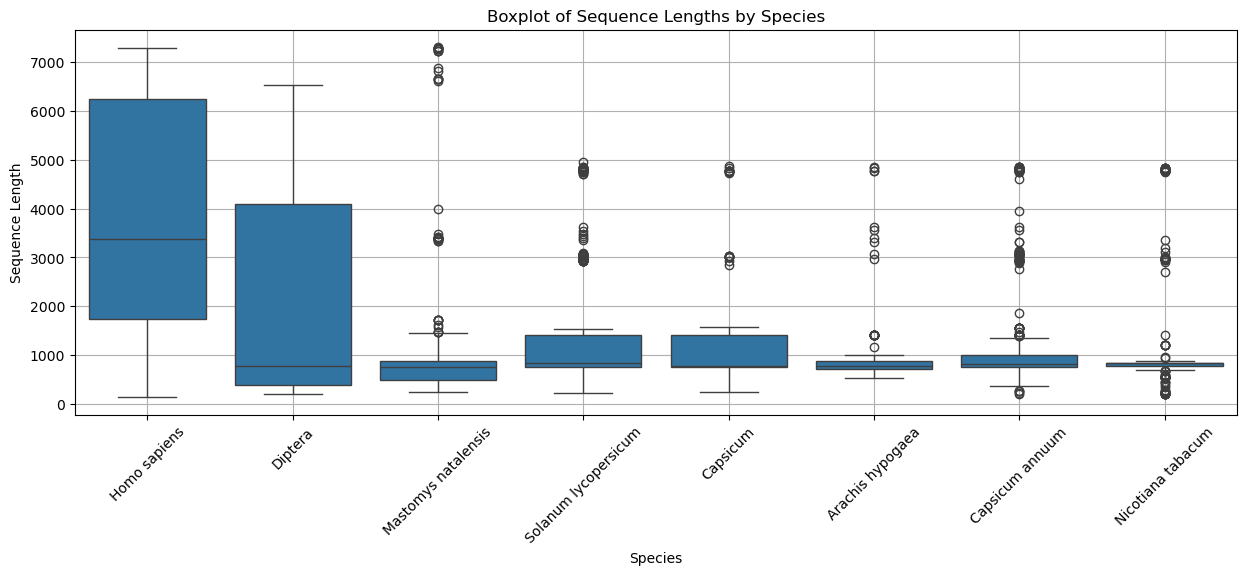

In [27]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=balanced_df, x='Y', y='sequence_len')
plt.title("Boxplot of Sequence Lengths by Species")
plt.xticks(rotation=45)
plt.xlabel('Species')
plt.ylabel('Sequence Length')
plt.grid(True)
plt.show()

# BINARY CLASSIFICATION MODELS

In [28]:
def one_hot_encode(seq, max_len, flatten=False):
    """
    Custom function for one hot encoding nucleotides based on
    Nucleotide IUPAC format followed by NIH
    """
    # Mapping each nucleotide to array format
    mapping = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'M': [0.5, 0.5, 0, 0],
        'R': [0.5, 0, 0.5, 0],
        'W': [0.5, 0, 0, 0.5],
        'S': [0, 0.5, 0.5, 0],
        'Y': [0, 0.5, 0, 0.5],
        'K': [0, 0, 0.5, 0.5],
        'V': [1/3, 1/3, 1/3, 0],
        'H': [1/3, 1/3, 0, 1/3],
        'D': [1/3, 0, 1/3, 1/3],
        'B': [0, 1/3, 1/3, 1/3]
    }

    # Truncate sequence longer than max length
    seq = seq.upper()[:max_len]

    encoded = []
    for base in seq:
        base = base.upper()
        encoded.append(mapping.get(base))

    # Zero pad the sequence to max length if needed
    pad_len = max_len - len(encoded)
    if pad_len > 0:
        encoded += [[0, 0, 0, 0]] * pad_len

    # Convert to NumPy array
    encoded_array = np.array(encoded, dtype='float32')

    # Flatten Sequence
    if flatten:
        encoded_array = encoded_array.flatten()

    return encoded_array

## Model 1: ANN

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report

In [30]:
# Extract maximum sequence length
max_len = bal_binary_df['sequence_len'].max()

# Create a column with the one hot encoded sequence flattened
df_ann_model = bal_binary_df.copy()
df_ann_model['ohe'] = df_ann_model['sequence'].apply(lambda seq: one_hot_encode(seq, max_len, flatten=True))
df_ann_model['ohe'].head()

0    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...
1    [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
2    [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
3    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
4    [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...
Name: ohe, dtype: object

In [31]:
# Use label encoder to extract classes for our Y column
Y = df_ann_model['y'].values
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
X = df_ann_model.drop(columns=['y'])

# test train split with test size of .2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

# Confirm that two classes were successfully extracted
len(label_encoder.classes_)

2

In [32]:
# Transform columns of arrays into a 2d matrix
X_stacked = np.stack(X_train['ohe'].tolist())
X_test_stacked = np.stack(X_test['ohe'].tolist())

# Confirm shape
X_stacked.shape

(14579, 29392)

In [33]:
model = tf.keras.models.Sequential()

# construct a basic ANN
model.add(layers.Input(shape=(X_stacked.shape[1],)))
model.add(layers.Dense(1024))
model.add(layers.Dense(512))
model.add(layers.Dense(256))

for i in range(0, 10):
    model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 1024)           │    30,098,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,511,426 (120.21 MB)

 Trainable params: 31,511,426 (120.21 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# fit the model
history = model.fit(X_stacked,
                    Y_train,
                    validation_split = 0.2,
                    epochs=100,
                    batch_size=10,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/100


I0000 00:00:1746992266.151847   26485 service.cc:152] XLA service 0x7a74080138d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746992266.151865   26485 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-05-11 15:37:46.183233: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746992266.446566   26485 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-11 15:37:47.302109: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_190_0', 216 bytes spill stores, 392 bytes spill loads

2025-05-11 15:37:47.314221: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot

  30/1167 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4912 - loss: 1.6531

I0000 00:00:1746992272.853955   26485 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1158/1167 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7486 - loss: 0.6231

2025-05-11 15:38:00.530091: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_190', 216 bytes spill stores, 248 bytes spill loads

2025-05-11 15:38:00.612767: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_190_0', 216 bytes spill stores, 392 bytes spill loads

2025-05-11 15:38:00.682084: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_190', 424 bytes spill stores, 544 bytes spill loads

2025-05-11 15:38:01.311133: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_190', 380 bytes spill stores, 380 bytes spill loads

2025-05-11 15:38:01.356763: I exte

1167/1167 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7492 - loss: 0.6218

2025-05-11 15:38:07.046040: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_58', 424 bytes spill stores, 544 bytes spill loads

2025-05-11 15:38:07.046604: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_58', 216 bytes spill stores, 248 bytes spill loads

2025-05-11 15:38:07.064767: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_58_0', 216 bytes spill stores, 392 bytes spill loads

2025-05-11 15:38:07.138568: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_58', 424 bytes spill stores, 424 bytes spill loads

2025-05-11 15:38:07.877892: I external

1167/1167 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.7493 - loss: 0.6216 - val_accuracy: 0.8591 - val_loss: 0.6534
Epoch 2/100
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9024 - loss: 0.2900 - val_accuracy: 0.9026 - val_loss: 0.2260
Epoch 3/100
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9187 - loss: 0.2632 - val_accuracy: 0.8786 - val_loss: 0.3204
Epoch 4/100
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9336 - loss: 0.2317 - val_accuracy: 0.8961 - val_loss: 0.2721
Epoch 5/100
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9417 - loss: 0.2029 - val_accuracy: 0.8961 - val_loss: 0.6626
Epoch 6/100
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9459 - loss: 0.2606 - val_accuracy: 0.9150 - val_loss: 0.2831
Epoch 7/100
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9562 - loss: 0.1593 - val_accuracy: 0.9132 - val_loss: 0.5286


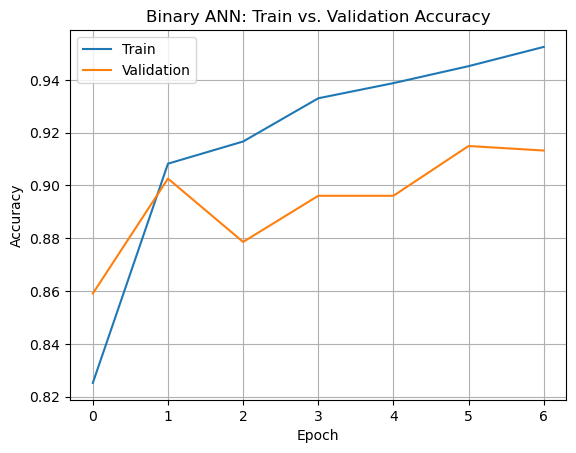

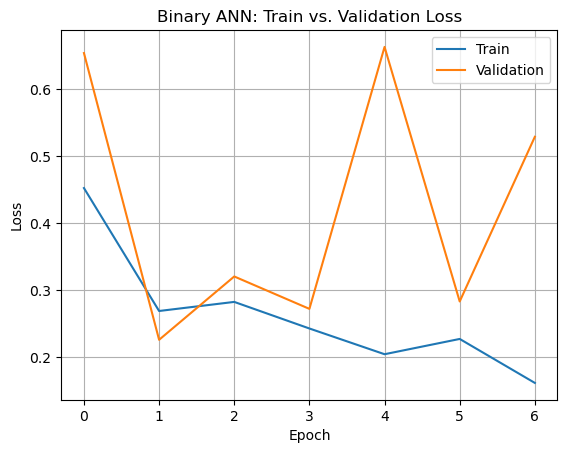

In [35]:
# plot accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Binary ANN: Train vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# plot loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Binary ANN: Train vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# evaluate the model
model.evaluate(X_test_stacked, Y_test, verbose=2)

2025-05-11 15:39:06.365819: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_58', 3660 bytes spill stores, 3644 bytes spill loads

2025-05-11 15:39:06.373393: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_58', 488 bytes spill stores, 488 bytes spill loads

2025-05-11 15:39:06.397041: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_58_0', 432 bytes spill stores, 1040 bytes spill loads

2025-05-11 15:39:06.464459: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_58', 608 bytes spill stores, 608 bytes spill loads

2025-05-11 15:39:07.017301: I exter

114/114 - 8s - 69ms/step - accuracy: 0.9059 - loss: 0.2301


[0.23012292385101318, 0.9058985114097595]

In [37]:
# Generate classification report for model
y_pred = model.predict(X_test_stacked)
predict = tf.argmax(y_pred, axis=1).numpy() 
report = classification_report(Y_test, predict, target_names=label_encoder.classes_)
print(report)

114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
              precision    recall  f1-score   support

       Human       0.88      0.95      0.91      1820
   Non-Human       0.94      0.87      0.90      1825

    accuracy                           0.91      3645
   macro avg       0.91      0.91      0.91      3645
weighted avg       0.91      0.91      0.91      3645



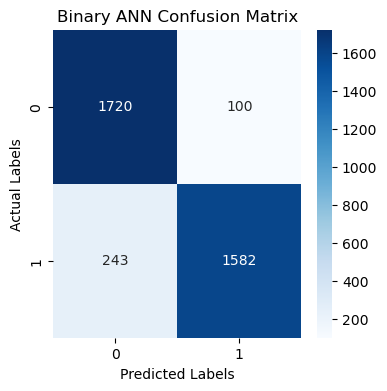

In [38]:
confusion_matrix = tf.math.confusion_matrix(Y_test, predict, num_classes=len(label_encoder.classes_))

# visualize confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Binary ANN Confusion Matrix')

plt.show()

## Model 2: CNN

In [39]:
# Extract maximum sequence length
max_len = bal_binary_df['sequence_len'].max()

# Create a column with the one hot encoded sequence
# Not flattened for CNN
df_cnn_model = bal_binary_df.copy()
df_cnn_model['ohe'] = df_cnn_model['sequence'].apply(lambda seq: one_hot_encode(seq, max_len))
df_cnn_model['ohe'].head()

0    [[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...
1    [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...
2    [[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...
3    [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...
4    [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...
Name: ohe, dtype: object

In [40]:
# Use label encoder to extract classes for our Y column
Y = df_cnn_model['y'].values
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
X = df_cnn_model.drop(columns=['y'], axis=1)

# test train split with test size of .2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

# Confirm that two classes were successfully extracted
len(label_encoder.classes_)

2

In [41]:
# Transform columns of arrays into a 2d matrix
X_stacked = np.stack(X_train['ohe'].tolist())

X_test_stacked = np.stack(X_test['ohe'].tolist())

# Confirm shape
X_stacked.shape

(14579, 7348, 4)

In [42]:
model = models.Sequential()

# 1D CNN
model.add(layers.Input(shape=(X_stacked.shape[1], 4)))

# First Convolutional Layer
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))

# Second Convolutional Layer
model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())

# Fully connected layer
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 7346, 64)       │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3673, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3671, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,922 (132.51 KB)

 Trainable params: 33,922 (132.51 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# fit the model
history = model.fit(X_stacked, Y_train,
          epochs=10,
          batch_size=10,
          validation_split=0.2,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.7730 - loss: 0.4619 - val_accuracy: 0.9005 - val_loss: 0.2467
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.9005 - loss: 0.2478 - val_accuracy: 0.8957 - val_loss: 0.2659
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.9107 - loss: 0.2232 - val_accuracy: 0.9177 - val_loss: 0.2053
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.9208 - loss: 0.1973 - val_accuracy: 0.9112 - val_loss: 0.2143
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.9242 - loss: 0.1945 - val_accuracy: 0.9026 - val_loss: 0.2484
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.9324 - loss: 0.1805 - val_accuracy: 0.9273 - val_loss: 0.1888
Epoch 7/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.9324 - loss: 0.1701 - val_accuracy: 0.9232 - val_loss: 0.2120
Epoch 8/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.9369 -

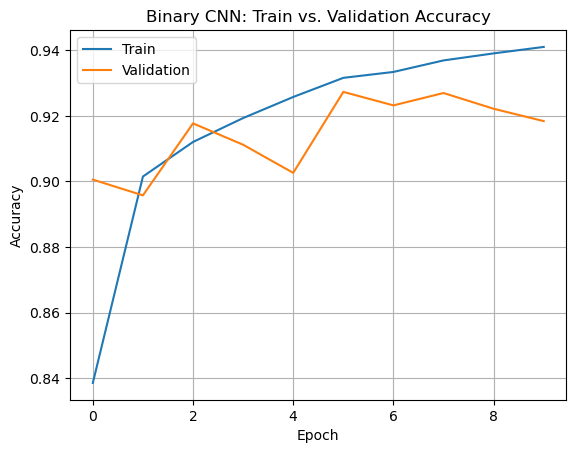

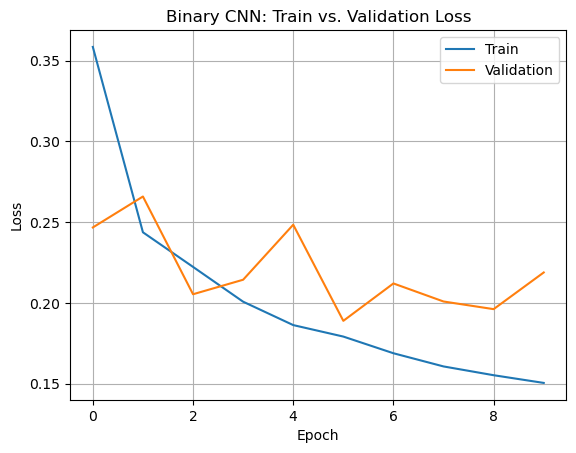

In [44]:
# plot accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Binary CNN: Train vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# plot loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Binary CNN: Train vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# evaluate the model
model.evaluate(X_test_stacked, Y_test, verbose=2)

114/114 - 2s - 15ms/step - accuracy: 0.9246 - loss: 0.1903


[0.19027739763259888, 0.924554169178009]

In [46]:
# Generate classification report for model
# y_pred = model(X_test_stacked)
y_pred = model.predict(X_test_stacked)
predict = tf.argmax(y_pred, axis=1).numpy() 
report = classification_report(Y_test, predict, target_names=label_encoder.classes_)
print(report)

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

       Human       0.92      0.93      0.92      1782
   Non-Human       0.93      0.92      0.93      1863

    accuracy                           0.92      3645
   macro avg       0.92      0.92      0.92      3645
weighted avg       0.92      0.92      0.92      3645



[[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 1.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[1. 0. 0. 0.]
  [0. 0. 0. 1.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[1. 0. 0. 0.]
  [0. 0. 0. 1.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


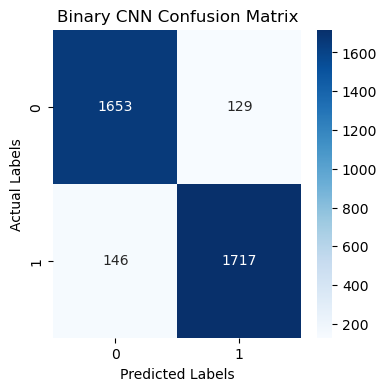

In [47]:
# create a confusion matrix from the test data
print(X_test_stacked)

# use argmax to get the actual values
predict = tf.argmax(y_pred, axis=1)

confusion_matrix = tf.math.confusion_matrix(Y_test, predict, num_classes=len(label_encoder.classes_))

# Visualize confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Binary CNN Confusion Matrix')

plt.show()

# MULTISPECIES CLASSIFICATION MODELS

Goal: Classify viral RNA sequences based on which host they infect

## Model 1: CNN (ReLu Activation Function ONLY)

In [48]:
# Extract maximum sequence length
max_len = balanced_df['sequence_len'].max()

# Create a column with the one hot encoded sequence
df_ms_model = balanced_df.copy()
df_ms_model['ohe'] = df_ms_model['sequence'].apply(lambda seq: one_hot_encode(seq, max_len))
df_ms_model['ohe'].head()

0    [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...
1    [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...
2    [[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...
3    [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...
4    [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...
Name: ohe, dtype: object

In [49]:
# Use label encoder to extract classes for our Y column
Y = df_ms_model['Y'].values
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
X = df_ms_model.drop(columns=['Y'], axis=1)

# test train split with test size of .2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

# Confirm that 8 classes were successfully extracted
len(label_encoder.classes_)

8

In [50]:
# Transform columns of arrays into a 2d matrix
X_stacked = np.stack(X_train['ohe'].tolist())
X_test_stacked = np.stack(X_test['ohe'].tolist())

# Confirm shape
X_stacked.shape

(2707, 7306, 4)

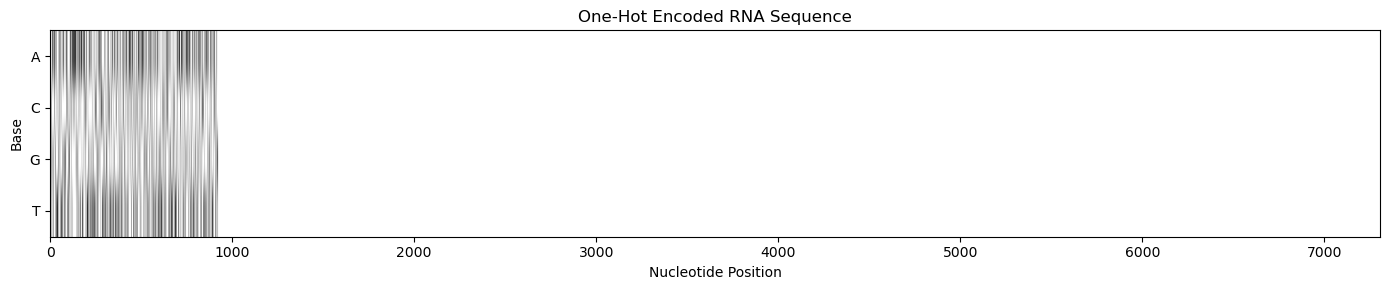

In [51]:
def visualize_onehot_sequence(onehot_seq, vmin=0.0, vmax=1.0):
    """
    Visualize a one-hot encoded RNA sequence using a heatmap.

    Parameters:
    - onehot_seq: numpy array of shape (sequence_length, 4)
    - vmin, vmax: color scale limits (default 0-1 for binary)
    """
    plt.figure(figsize=(14, 3))
    im = plt.imshow(onehot_seq.T, aspect='auto', cmap='gray_r')
    plt.title("One-Hot Encoded RNA Sequence")
    plt.xlabel("Nucleotide Position")
    plt.ylabel("Base")
    plt.yticks([0, 1, 2, 3], ["A", "C", "G", "T"])
    plt.tight_layout()
    plt.show()

# Visualize the first training example
visualize_onehot_sequence(X_stacked[288])

In [52]:
model = models.Sequential()

# 1D CNN
model.add(layers.Input(shape=(X_stacked.shape[1], 4)))

# First Convolutional Layer
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))

# Second Convolutional Layer
model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))

# Third Convolutional Layer
model.add(layers.Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())

# Fully connected layer
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 7304, 64)       │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3652, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 3650, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1825, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1823, 256)      │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,064 (551.03 KB)

 Trainable params: 141,064 (551.03 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
history = model.fit(X_stacked,
          Y_train,
          epochs=10,
          batch_size=20,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
          validation_split=0.2)

Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.1570 - loss: 2.0698 - val_accuracy: 0.3708 - val_loss: 1.7676
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4179 - loss: 1.6219 - val_accuracy: 0.7196 - val_loss: 1.0034
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6326 - loss: 1.0453 - val_accuracy: 0.7915 - val_loss: 0.6899
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7383 - loss: 0.7683 - val_accuracy: 0.8155 - val_loss: 0.5647
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7718 - loss: 0.6335 - val_accuracy: 0.8118 - val_loss: 0.5208
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8139 - loss: 0.5011 - val_accuracy: 0.8118 - val_loss: 0.5123
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8194 - loss: 0.5157 - val_accuracy: 0.7860 - val_loss: 0.5139
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8412 - loss: 0.4396 - val_accu

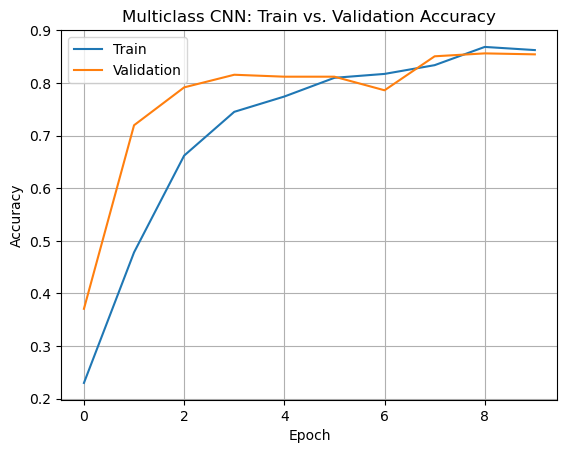

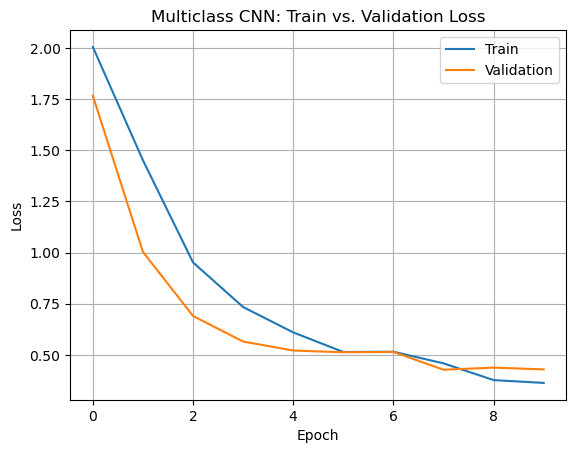

In [54]:
# plot accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Multiclass CNN: Train vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# plot loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Multiclass CNN: Train vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
model.evaluate(X_test_stacked, Y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8119 - loss: 0.4857


[0.4840516448020935, 0.8257016539573669]

In [56]:
# Generate classification report for model
y_pred = model.predict(X_test_stacked)
predict = tf.argmax(y_pred, axis=1).numpy() 
report = classification_report(Y_test, predict, target_names=label_encoder.classes_)
print(report)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
                      precision    recall  f1-score   support

    Arachis hypogaea       0.91      0.90      0.90        88
            Capsicum       0.92      0.87      0.89        89
     Capsicum annuum       0.51      0.73      0.60        73
             Diptera       0.96      0.97      0.96        97
        Homo sapiens       0.94      0.97      0.95        93
 Mastomys natalensis       0.99      0.93      0.95        80
   Nicotiana tabacum       0.89      0.70      0.78        79
Solanum lycopersicum       0.52      0.47      0.50        78

            accuracy                           0.83       677
           macro avg       0.83      0.82      0.82       677
        weighted avg       0.84      0.83      0.83       677



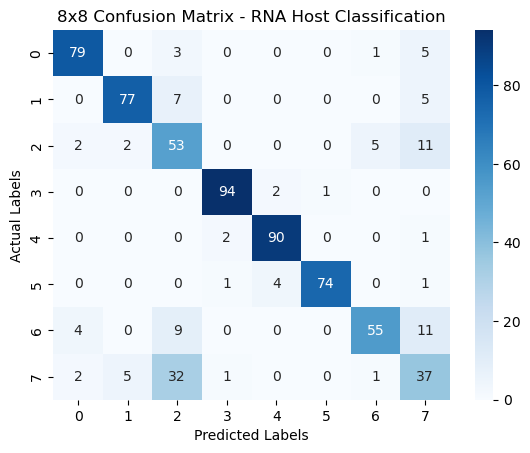

In [57]:
# create a confusion matrix from the test data
# use argmax to get the actual values
predict = tf.argmax(y_pred, axis=1)

confusion_matrix = tf.math.confusion_matrix(Y_test, predict, num_classes=len(label_encoder.classes_))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title("8x8 Confusion Matrix - RNA Host Classification")

plt.show();

## Model 2: CNN (ReLu + Leaky ReLu Activation Functions)

In [58]:
model = models.Sequential()

# 1D CNN
model.add(layers.Input(shape=(X_stacked.shape[1], 4)))

# First Convolutional Layer
model.add(layers.Conv1D(filters=64, kernel_size=3, activation=tf.keras.activations.leaky_relu))
model.add(layers.MaxPooling1D(pool_size=2))

# Second Convolutional Layer
model.add(layers.Conv1D(filters=128, kernel_size=3, activation= 'relu'))
model.add(layers.MaxPooling1D(pool_size=2))

# Third Convolutional Layer
model.add(layers.Conv1D(filters=256, kernel_size=3, activation=tf.keras.activations.leaky_relu))
model.add(layers.GlobalMaxPooling1D())

# Fully connected layer
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 7304, 64)       │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 3652, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 3650, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1825, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 1823, 256)      │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,064 (551.03 KB)

 Trainable params: 141,064 (551.03 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
history = model.fit(X_stacked,
          Y_train,
          epochs=100,
          batch_size=20,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
          validation_split=0.2)

Epoch 1/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.1499 - loss: 2.0665 - val_accuracy: 0.3303 - val_loss: 1.7358
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3852 - loss: 1.5974 - val_accuracy: 0.6421 - val_loss: 1.0602
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5962 - loss: 1.0960 - val_accuracy: 0.7823 - val_loss: 0.6868
Epoch 4/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7142 - loss: 0.8014 - val_accuracy: 0.7952 - val_loss: 0.6354
Epoch 5/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7606 - loss: 0.6545 - val_accuracy: 0.8432 - val_loss: 0.4900
Epoch 6/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7811 - loss: 0.5835 - val_accuracy: 0.8266 - val_loss: 0.5131
Epoch 7/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8092 - loss: 0.5116 - val_accuracy: 0.8432 - val_loss: 0.4396
Epoch 8/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8483 - loss: 0.4384 - 

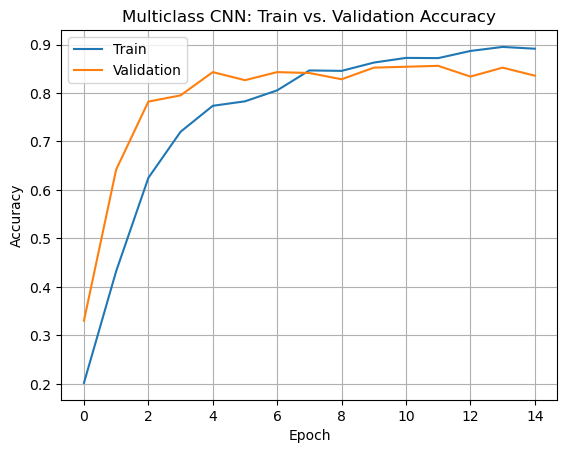

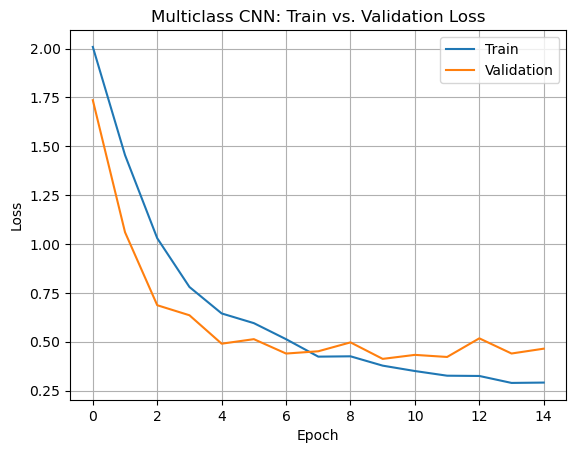

In [60]:
# plot accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Multiclass CNN: Train vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# plot loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Multiclass CNN: Train vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
model.evaluate(X_test_stacked, Y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8399 - loss: 0.5117


[0.5102084279060364, 0.8389955759048462]

In [62]:
# Generate classification report for model
y_pred = model.predict(X_test_stacked)
predict = tf.argmax(y_pred, axis=1).numpy() 
report = classification_report(Y_test, predict, target_names=label_encoder.classes_)
print(report)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
                      precision    recall  f1-score   support

    Arachis hypogaea       0.95      0.91      0.93        88
            Capsicum       0.91      0.83      0.87        89
     Capsicum annuum       0.68      0.56      0.62        73
             Diptera       0.96      0.92      0.94        97
        Homo sapiens       0.93      0.97      0.95        93
 Mastomys natalensis       0.93      0.97      0.95        80
   Nicotiana tabacum       0.90      0.70      0.79        79
Solanum lycopersicum       0.52      0.78      0.63        78

            accuracy                           0.84       677
           macro avg       0.85      0.83      0.83       677
        weighted avg       0.86      0.84      0.84       677



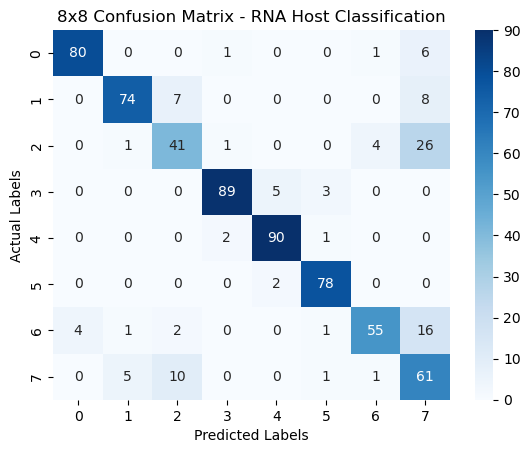

In [63]:
# create a confusion matrix from the test data
# use argmax to get the actual values
predict = tf.argmax(y_pred, axis=1)

confusion_matrix = tf.math.confusion_matrix(Y_test, predict, num_classes=len(label_encoder.classes_))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title("8x8 Confusion Matrix - RNA Host Classification")

plt.show();

# Identifying Crucial RNA Sequence Regions for Viral Host Infiltration

### Entopy Plot - Single Sequence

In [64]:
from scipy.stats import entropy
from collections import defaultdict
import random

In [65]:
# function to delete sections of a signle rna sequence w sliding window and run model on each
# sequence w deletions
def delete_pad_predictions(original_seq, model, max_len=30, window_size=5, stride=1):
    # force input to not be longer than the model expects (currently expects shape (30, 4))
    original_seq = original_seq[:max_len]

    # store the output probabilities and positions of deletions
    deleted_probs = []
    positions = []

    # loop only within the fixed-length input
    for i in range(0, len(original_seq) - window_size + 1, stride):
        # delete window region
        shortened = original_seq[:i] + original_seq[i + window_size:]

        # pad back up to fixed length to be compatible with what model expects
        encoded = one_hot_encode(shortened, max_len=max_len)
        encoded = np.expand_dims(encoded, axis=0)  # Add batch dim

        pred = model.predict(encoded, verbose=0)[0]

        deleted_probs.append(pred)
        positions.append(i)

    return np.array(positions), np.array(deleted_probs)


In [66]:
# Choose a sample from test set
sample_index = 0
sample_seq = X_test.iloc[sample_index]['sequence']
true_class = Y_test[sample_index]

len(sample_seq)

759

In [67]:
def plot_entropy_vs_position(probs, positions, label=None):
    # apply entropy() function from scipy to each row of probs
    # this gives you the uncertainty of the preds
    entropies = [entropy(p) for p in probs]

    plt.figure(figsize=(10, 4))
    plt.plot(positions, entropies, marker='o')
    
    title = "Prediction Entropy Across Deleted Regions"
    if label:
        title += f"\n(True Class: {label})"
        
    plt.title(title)
    plt.xlabel("Deletion Start Position (nt)")
    plt.ylabel("Entropy (Uncertainty)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

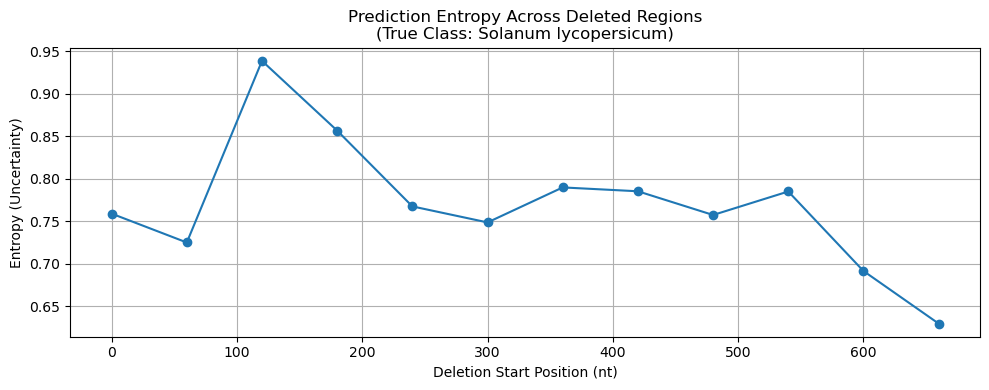

In [68]:
# get the actual class name of whatever sequence is being analyized to add to plot
true_class_name = label_encoder.inverse_transform([Y_test[sample_index]])[0]

# get the deletion start positions and corresponding prediction probabilities
positions, probs = delete_pad_predictions(sample_seq, model, max_len=X_stacked.shape[1], window_size=60, stride=60)

# plot entropy graph
plot_entropy_vs_position(probs, positions, label=true_class_name)


### Entropy Plot - Multiple Sequences and Species

In [69]:
# Function to delete segments of an RNA sequence, re-pad it to model input length, 
# and collect model predictions on these modified sequences
def delete_pad_predictions(original_seq, model, max_len=X_stacked.shape[1], window_size=30, stride=10):
    # Truncate sequence to max model input length
    original_seq = original_seq[:max_len]
    deleted_probs = []   # store probabilities after deletion
    positions = []  # store deletion start positions

    # Slide deletion window across sequence
    for i in range(0, len(original_seq) - window_size + 1, stride):
        shortened = original_seq[:i] + original_seq[i + window_size:]
        encoded = one_hot_encode(shortened, max_len=max_len)
        encoded = np.expand_dims(encoded, axis=0)
        pred = model.predict(encoded, verbose=0)[0]
        deleted_probs.append(pred)
        positions.append(i)

    return np.array(positions), np.array(deleted_probs)

In [70]:
# Run deletion analysis for all sequences, grouped by class
def delete_pad_by_class(sequences, labels, model, label_encoder, max_len=X_stacked.shape[1], window_size=30, stride=10):
    class_data = {}

    for seq, label in zip(sequences, labels):
        positions, probs = delete_pad_predictions(seq, model, max_len, window_size, stride)
        class_name = label_encoder.inverse_transform([label])[0]
        class_data.setdefault(class_name, []).append(probs)

    return class_data, positions

In [71]:
# Plot average entropy per deletion window for each class
def plot_stacked_entropy_by_class(class_data, positions, max_classes=None):
    classes = list(class_data.keys())
    if max_classes:
        classes = classes[:max_classes]

    fig, axes = plt.subplots(len(classes), 1, figsize=(8, len(classes) * 1.6), sharex=True)

    # Plot entropy for each class
    for i, class_name in enumerate(classes):
        # Truncate to the shortest sequence for consistent stacking
        min_len = min(p.shape[0] for p in class_data[class_name])
        class_probs = np.stack([p[:min_len] for p in class_data[class_name]])
        # Compute entropy across predictions at each deletion window
        entropies = np.apply_along_axis(entropy, 2, class_probs)
        avg_entropy = np.nanmean(entropies, axis=0)

        min_len = min(len(positions), len(avg_entropy))
        trimmed_positions = np.array(positions[:min_len])
        avg_entropy = avg_entropy[:min_len]

        # Plot the entropy curve for the class
        ax = axes[i] if len(classes) > 1 else axes
        ax.plot(trimmed_positions, avg_entropy, color='black')
        ax.set_ylabel(class_name, fontsize=8, rotation=0, ha='right', va='center')
        ax.set_yticks([])
        ax.set_xlim(0, trimmed_positions[-1])

    plt.xlabel("Deletion Start Position (nt)")
    plt.suptitle("Entropy by Class Across Deleted RNA Regions", y=1.01)
    plt.tight_layout()
    plt.show()

In [72]:
# only want to plot entropy graphs for top species identified in EDA section
target_species = [
    "Homo sapiens",
    "Mastomys natalensis",
    "Arachis hypogaea",
    "Solanum lycopersicum",
    "Capsicum",
    "Capsicum annuum",
    "Diptera",
    "Nicotiana tabacum"
]

# select subset of species from main df
df_subset = df_ms_model[df_ms_model['Y'].isin(target_species)]

# set number of samples per class/species
n_per_class = 15  # can adjust based on runtime

# filter to only keep sequences between 650 and 850 nt to be able to graph 
# all on same X-axis and be interpretable
filtered_df_subset = df_subset[df_subset['sequence_len'].between(650, 850)]

sampled_rows = []

# sample n_per_class sequences per species
for species in target_species:
    # for each species, get only the sequences that pass the filter
    species_rows = filtered_df_subset[filtered_df_subset['Y'] == species]
    sample_size = min(len(species_rows), n_per_class)
    sampled = species_rows.sample(n=sample_size, random_state=42)
    sampled_rows.append(sampled)

# combine all sampled rows into one df
sampled_df = pd.concat(sampled_rows).reset_index(drop=True)

# truncate sequences to match model expected input length (X_stacked.shape[1])
sample_sequences = [seq[:X_stacked.shape[1]] for seq in sampled_df['sequence']]

# encode the labels using label_encoder
sample_labels = label_encoder.transform(sampled_df['Y'].tolist())


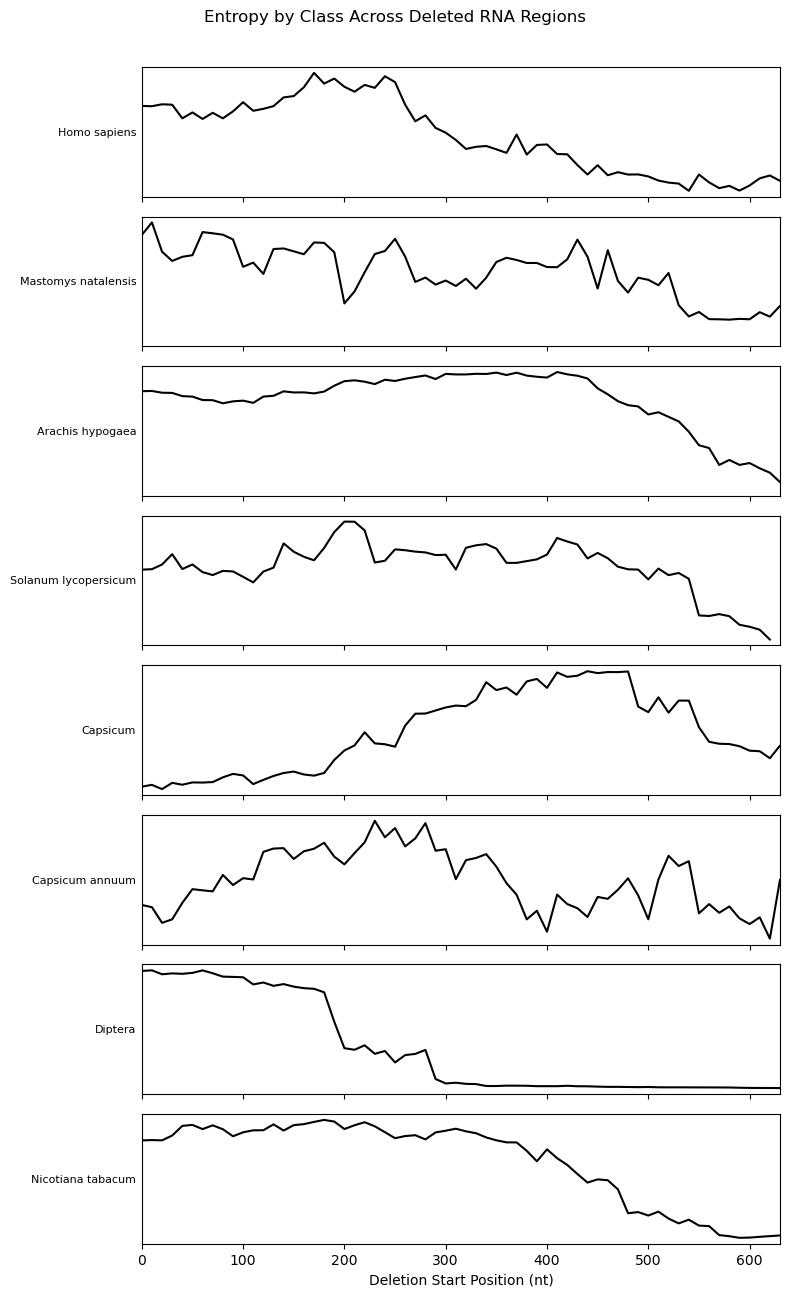

In [65]:
# calling sliding window on the filtered samples by species
class_data, positions = delete_pad_by_class(
    sample_sequences,
    sample_labels,
    model,
    label_encoder,
    max_len=X_stacked.shape[1],
    window_size=30,
    stride=10
)

# entropy plots for the top 8 species
plot_stacked_entropy_by_class(class_data, positions, max_classes=len(target_species))


### Investigating Flattening of Plot for Diptera

In [66]:
# printing Diptera sequence length for the filtered sequences
diptera_lengths = filtered_df_subset[filtered_df_subset['Y'] == 'Diptera']['sequence_len']
print("Diptera sequence length stats:")
print(diptera_lengths.describe())


Diptera sequence length stats:
count     32.0
mean     783.0
std        0.0
min      783.0
25%      783.0
50%      783.0
75%      783.0
max      783.0
Name: sequence_len, dtype: float64


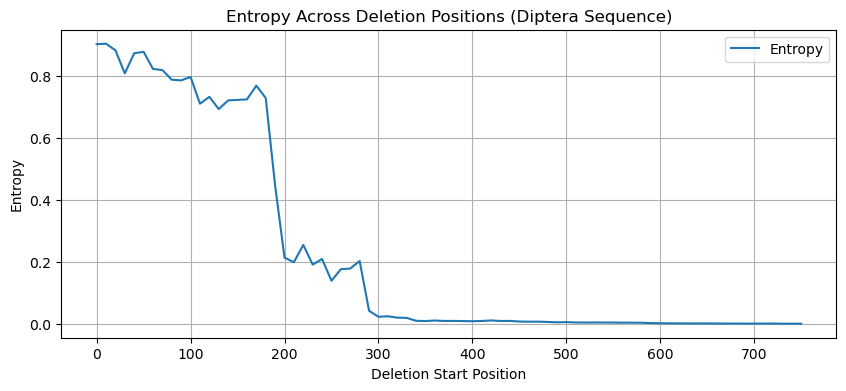

In [67]:
# Get one Diptera sequence from the sampled df
diptera_seq = sampled_df[sampled_df['Y'] == 'Diptera'].iloc[0]['sequence']
diptera_seq = diptera_seq[:X_stacked.shape[1]]  # truncate

# Run deletion-prediction
positions, diptera_probs = delete_pad_predictions(
    diptera_seq, model, max_len=X_stacked.shape[1], window_size=30, stride=10
)

# Compute entropy
diptera_entropy = [entropy(p) for p in diptera_probs]

# Plot both entropy and predicted class
plt.figure(figsize=(10, 4))
plt.plot(positions, diptera_entropy, label='Entropy')
plt.xlabel("Deletion Start Position")
plt.ylabel("Entropy")
plt.title("Entropy Across Deletion Positions (Diptera Sequence)")
plt.grid(True)
plt.legend()
plt.show()


In [68]:
# All Diptera sequences before length filtering
diptera_all = df[df['Y'] == 'Diptera']
print("Total Diptera sequences:", len(diptera_all))
print(diptera_all['sequence_len'].describe())


Total Diptera sequences: 440
count     440.000000
mean     1886.827273
std      1966.362148
min       201.000000
25%       389.000000
50%       783.000000
75%      4089.000000
max      6520.000000
Name: sequence_len, dtype: float64


In [69]:
# Showing count of diptera sequences for each sequence length in our data
print(diptera_all['sequence_len'].value_counts().head(10))

sequence_len
1611    45
4089    38
783     33
441     31
363     25
246     25
438     22
4164     7
1682     7
6282     7
Name: count, dtype: int64


In [70]:
# Filter Diptera sequences with length 783
diptera_783 = df[df['Y'] == 'Diptera']
diptera_783 = diptera_783[diptera_783['sequence_len'] == 783]

print(f"Total Diptera sequences of length 783: {len(diptera_783)}")

# Check for exact duplicates
unique_seqs = diptera_783['sequence'].nunique()
print(f"Unique sequences among them: {unique_seqs}")

Total Diptera sequences of length 783: 33
Unique sequences among them: 29


### Entopy Plots - Normalized Deletion Positions

In [71]:
def compute_normalized_entropy_by_class(sequences, labels, model, label_encoder,
                                        max_len=X_stacked.shape[1], window_size=30, stride=30, bins=100,
                                        max_seqs_per_class=5):
    """
    Normalize deletion positions across all sequence lengths into bins/percent of sequence length.
    Compute average entropy per class per bin.
    Limits number of sequences per class to speed up runtime.
    """
    # Each class gets a list of bins, each bin holds entropy values from deletions
    class_entropy = defaultdict(lambda: [[] for _ in range(bins)])
    class_counts = defaultdict(int)

    # Shuffle everything so the first N sequences per class aren't always the same
    shuffled = list(zip(sequences, labels))
    random.shuffle(shuffled)

    for seq, label in shuffled:
        class_name = label_encoder.inverse_transform([label])[0]

        # Cap how many sequences we analyze per class
        if class_counts[class_name] >= max_seqs_per_class:
            continue
        class_counts[class_name] += 1

        # Cut sequence down to max allowed length for the model
        seq = seq[:max_len]
        probs = []
        positions = []

        # Slide a deletion window across the sequence
        for i in range(0, len(seq) - window_size + 1, stride):
            shortened = seq[:i] + seq[i + window_size:]
            encoded = one_hot_encode(shortened, max_len=max_len)
            encoded = np.expand_dims(encoded, axis=0)  # model expects batch dimension
            pred = model.predict(encoded, verbose=0)[0]
            probs.append(pred)
            positions.append(i)

        if not probs:
            continue  # skip empty or too-short sequences

        # Turn list of predicted distributions into entropy values
        probs = np.array(probs)
        entropies = np.apply_along_axis(entropy, 1, probs)

        # Map deletion positions to normalized bin index (0–100%)
        norm_pos = np.array(positions) / len(seq)
        bin_indices = np.floor(norm_pos * bins).astype(int)
        bin_indices = np.clip(bin_indices, 0, bins - 1)

        # Drop entropy values into the appropriate bins for this class
        for b, e in zip(bin_indices, entropies):
            class_entropy[class_name][b].append(e)

    # Return bin labels in percent and the grouped entropy values
    return class_entropy, np.linspace(0, 100, bins)

In [72]:
def plot_stacked_normalized_entropy(class_entropy, norm_x):
    # Grab all the class labels
    classes = list(class_entropy.keys())

    # One subplot per class/species
    fig, axes = plt.subplots(len(classes), 1, figsize=(8, len(classes) * 1.5), sharex=True)

    # If there's only one class, wrap axes in a list to keep indexing consistent
    if len(classes) == 1:
        axes = [axes]

    for i, class_name in enumerate(classes):
        # For each bin, compute average entropy (skip empty bins with NaN)
        avg_ent = [np.mean(bin) if bin else np.nan for bin in class_entropy[class_name]]

        # Plot average entropy across normalized position bins
        axes[i].plot(norm_x, avg_ent, color='black')
        axes[i].set_ylabel(class_name, fontsize=8, rotation=0, ha='right', va='center')
        axes[i].set_yticks([])

    plt.xlabel("Relative Sequence Position (%)")
    plt.suptitle("Entropy Across Normalized RNA Regions by Species", y=1.01)
    plt.tight_layout()
    plt.show()


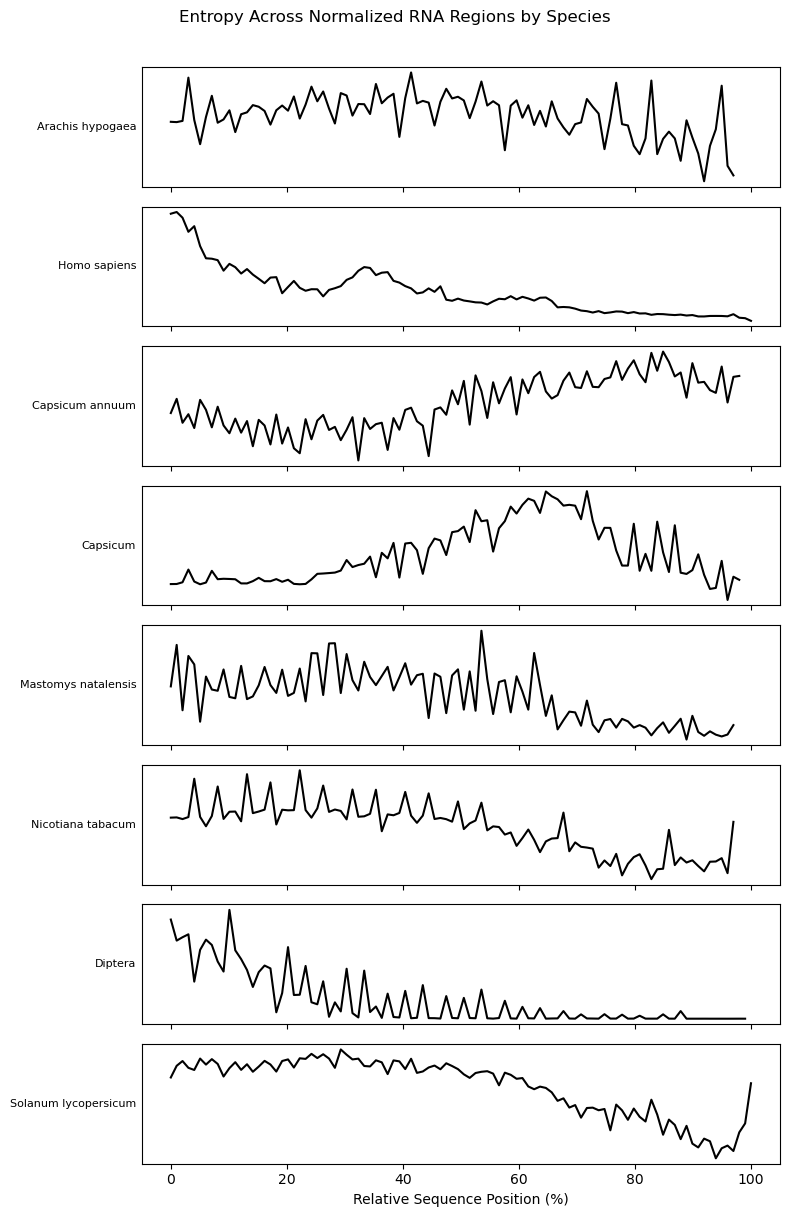

In [73]:
# Select species and filter rows
target_species = [
    "Homo sapiens", "Mastomys natalensis", "Arachis hypogaea",
    "Solanum lycopersicum", "Capsicum", "Capsicum annuum",
    "Diptera", "Nicotiana tabacum"
]
df_subset = df_ms_model[df_ms_model['Y'].isin(target_species)]

# Get sequences and encoded labels
sequences = df_subset['sequence'].tolist()
labels = label_encoder.transform(df_subset['Y'].tolist())

# Run entropy computation and plot
class_entropy, norm_x = compute_normalized_entropy_by_class(
    sequences, labels, model, label_encoder,
    max_len=X_stacked.shape[1], window_size=30, stride=10, bins=100
)

plot_stacked_normalized_entropy(class_entropy, norm_x)


# Recreating Viral RNA For Human Hosts

## AutoEncoder

Goal: Train an autoencoder on RNA sequences from viral RNA that infects Human Hosts.

In [73]:
human_df_ = df_binary[df_binary['y'] == 'Human']

In [74]:
def replace_ambiguous_bases(seq):
    """
    Replace ambiguous bases in a sequence with A/C/G/T equivalents.
    """
    # Set seed for reproducibility
    random.seed(42)

    # IUPAC codes for ambiguous bases
    IUPAC_TO_ACTG = {
        'A': ['A'],
        'C': ['C'],
        'G': ['G'],
        'T': ['T'],
        'M': ['A', 'C'],
        'R': ['A', 'G'],
        'W': ['A', 'T'],
        'S': ['C', 'G'],
        'Y': ['C', 'T'],
        'K': ['G', 'T'],
        'V': ['A', 'C', 'G'],
        'H': ['A', 'C', 'T'],
        'D': ['A', 'G', 'T'],
        'B': ['C', 'G', 'T']
    }

    new_seq = []
    for base in seq.upper():
        options = IUPAC_TO_ACTG[base]
        new_base = random.choice(options)
        new_seq.append(new_base)

    return ''.join(new_seq)

In [75]:
# Convert ambigious bases to A/C/G/T equivalents
human_df = human_df_.copy()
human_df['sequence_na'] = human_df['sequence'].apply(replace_ambiguous_bases)

In [76]:
# Train/test split on the DataFrame
split_index = int(len(human_df) * 0.8)
train_df = human_df.iloc[:split_index]
test_df = human_df.iloc[split_index:].reset_index(drop=True)

# one hot encode the sequences, length of 1000
train_df = train_df.copy()
test_df = test_df.copy()
train_df['ohe'] = train_df['sequence_na'].apply(lambda seq: one_hot_encode(seq, 1000))
test_df['ohe'] = test_df['sequence_na'].apply(lambda seq: one_hot_encode(seq, 1000))


# Create a column with the one hot encoded sequence
X_train = np.stack(train_df['ohe'].tolist())
X_test = np.stack(test_df['ohe'].tolist())

In [77]:
from tensorflow.keras.regularizers import l2

In [78]:
# Autoencoder parameters
latent_dim = 512     # Dimension of the latent (compressed) space
input_shape = (1000, 4)   # Shape of input

""""Encoder Model Definition"""
# Define the input layer
inputs = layers.Input(shape=input_shape)

# First Convolutional Layer
x = layers.Conv1D(64, kernel_size=5, activation="relu", padding="same", kernel_regularizer=l2(1e-5))(inputs)
x = layers.MaxPooling1D(pool_size=2)(x)

# Second Convolutional Layer
x = layers.Conv1D(128, kernel_size=5, activation="relu", padding="same", kernel_regularizer=l2(1e-5))(x)
x = layers.MaxPooling1D(pool_size=2)(x)

# Third Convolutional Layer
x = layers.Conv1D(128, kernel_size=5, activation="relu", padding="same", kernel_regularizer=l2(1e-5))(x)
x = layers.MaxPooling1D(pool_size=2)(x)


x = layers.Flatten()(x)
latent = layers.Dense(latent_dim, activation="relu", kernel_regularizer=l2(1e-5), name="latent_vector")(x)

"""Decoder Model Definition"""
# Decoder input layer
decoder_input = layers.Input(shape=(latent_dim,))

# Project latent space back to flattened shape
x = layers.Dense(125*128, activation="relu")(decoder_input)

# Reshape back to (125, 128)
x = layers.Reshape((125, 128))(x)

# Upsample to 250
x = layers.Conv1DTranspose(128, kernel_size=4, strides=2, padding="same", kernel_regularizer=l2(1e-5))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

# Upsample to 500
x = layers.Conv1DTranspose(128, kernel_size=4, strides=2, padding="same", kernel_regularizer=l2(1e-5))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

# Upsample to 1000 (original length)
x = layers.Conv1DTranspose(64, kernel_size=4, strides=2, padding="same", kernel_regularizer=l2(1e-5))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

# Final layer to reconstruct nucleotide probabilities (4 channels)
outputs = layers.Conv1D(filters=4, kernel_size=5, activation="softmax", padding="same")(x)

# Create the encoder and decoder models
encoder = models.Model(inputs, latent, name="encoder")
decoder = models.Model(decoder_input, outputs, name="decoder") 

# Autoencoder model
autoencoder_output = decoder(encoder(inputs))
autoencoder = models.Model(inputs, autoencoder_output, name="autoencoder")

# Print the encoder and decoder summaries
print("Encoder Model Summary:")
encoder.summary()

print("\nDecoder Model Summary:")
decoder.summary()

Encoder Model Summary:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1000, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 1000, 64)       │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 500, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 250, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 125, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 512)            │     8,192,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,316,992 (31.73 MB)

 Trainable params: 8,316,992 (31.73 MB)

 Non-trainable params: 0 (0.00 B)


Decoder Model Summary:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 16000)          │     8,208,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 125, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 250, 128)       │        65,664 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 250, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 500, 128)       │        65,664 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 500, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 1000, 64)       │        32,832 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 1000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 1000, 4)        │         1,284 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,374,724 (31.95 MB)

 Trainable params: 8,374,084 (31.94 MB)

 Non-trainable params: 640 (2.50 KB)

In [79]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [80]:
# Compile the autoencoder model with the Adam optimizer
# Set learning rate to 0.0001
# Scale gradients to prevent exploding gradients
autoencoder.compile(
    optimizer=Adam(learning_rate=0.0001, clipnorm=1.0),
    loss='categorical_crossentropy', # Use categorical crossentropy for multi-class
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# Reduce learning rate when validation loss has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the autoencoder
history = autoencoder.fit(
    X_train, X_train,
    batch_size=200,
    epochs=200,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/200


2025-05-11 15:46:54.999536: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_594', 128 bytes spill stores, 128 bytes spill loads

2025-05-11 15:46:55.187069: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2361', 60 bytes spill stores, 60 bytes spill loads

2025-05-11 15:46:55.210081: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_594', 2916 bytes spill stores, 2888 bytes spill loads

2025-05-11 15:46:55.239481: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_594', 476 bytes spill stores, 476 bytes spill loads

2025-05-11 15:46:55.531986: I exter

29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4435 - loss: 1.2245

2025-05-11 15:47:03.333383: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_594', 36 bytes spill stores, 36 bytes spill loads

2025-05-11 15:47:03.457028: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_594', 476 bytes spill stores, 476 bytes spill loads

2025-05-11 15:47:04.045777: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_594', 2916 bytes spill stores, 2888 bytes spill loads



30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.4474 - loss: 1.2182

2025-05-11 15:47:09.061041: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_209', 476 bytes spill stores, 476 bytes spill loads

2025-05-11 15:47:09.123181: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_209', 128 bytes spill stores, 128 bytes spill loads

2025-05-11 15:47:09.138652: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_209', 336 bytes spill stores, 336 bytes spill loads

2025-05-11 15:47:09.328565: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_209', 2916 bytes spill stores, 2888 bytes spill loads



30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 315ms/step - accuracy: 0.4511 - loss: 1.2124 - val_accuracy: 0.2902 - val_loss: 1.2732 - learning_rate: 1.0000e-04
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7247 - loss: 0.6998 - val_accuracy: 0.2887 - val_loss: 1.2716 - learning_rate: 1.0000e-04
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8035 - loss: 0.5183 - val_accuracy: 0.2887 - val_loss: 1.2701 - learning_rate: 1.0000e-04
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8333 - loss: 0.4431 - val_accuracy: 0.2887 - val_loss: 1.2688 - learning_rate: 1.0000e-04
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8410 - loss: 0.4226 - val_accuracy: 0.2884 - val_loss: 1.2675 - learning_rate: 1.0000e-04
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8532 - loss: 0.3809 - val_accuracy: 0.2456 - val_loss: 1.2666 - learning_rate: 1.0000e-04
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8601 - l

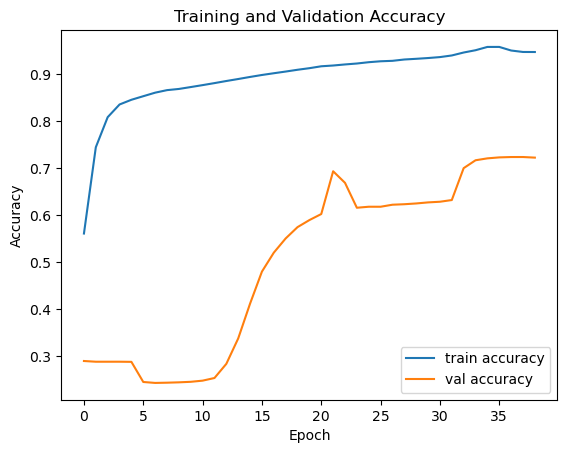

In [81]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [82]:
def visualize_input_vs_output(autoencoder, X, index=0, vmin=0.0, vmax=1.0):
    """
    Visualizes an original one-hot encoded RNA sequence and its reconstruction from a trained autoencoder.

    Parameters
    ----------
    autoencoder : keras.Model
        A trained autoencoder model used for reconstructing the input sequence
    X : np.ndarray
        Input array of shape (num_samples, sequence_length, 4) containing one-hot encoded sequences
    index : int, optional
        Index of the sequence in `X` to visualize (default is 0)
    vmin : float, optional
        Minimum value for color scaling in the heatmaps (default is 0.0)
    vmax : float, optional
        Maximum value for color scaling in the heatmaps (default is 1.0)
    """
    # Get the sequence at the specified index and reconstruct it
    original = X[index]
    reconstructed = autoencoder.predict(X[index][None, ...], verbose=0)[0]

    # Plot the original and reconstructed sequences
    fig, axes = plt.subplots(2, 1, figsize=(14, 5), sharex=True)

    # Original Input
    im0 = axes[0].imshow(original.T, aspect='auto', cmap='gray_r', vmin=vmin, vmax=vmax)
    axes[0].set_title("Original Input Sequence")
    axes[0].set_ylabel("Base (A, C, G, T)")
    axes[0].set_yticks([0, 1, 2, 3])
    axes[0].set_yticklabels(["A", "C", "G", "T"])
    fig.colorbar(im0, ax=axes[0], orientation='vertical', shrink=0.6)

    # Reconstructed Output
    im1 = axes[1].imshow(reconstructed.T, aspect='auto', cmap='gray_r', vmin=vmin, vmax=vmax)
    axes[1].set_title("Reconstructed Output Sequence")
    axes[1].set_xlabel("Sequence Position")
    axes[1].set_ylabel("Base (A, C, G, T)")
    axes[1].set_yticks([0, 1, 2, 3])
    axes[1].set_yticklabels(["A", "C", "G", "T"])
    fig.colorbar(im1, ax=axes[1], orientation='vertical', shrink=0.6)

    plt.tight_layout()
    plt.show()

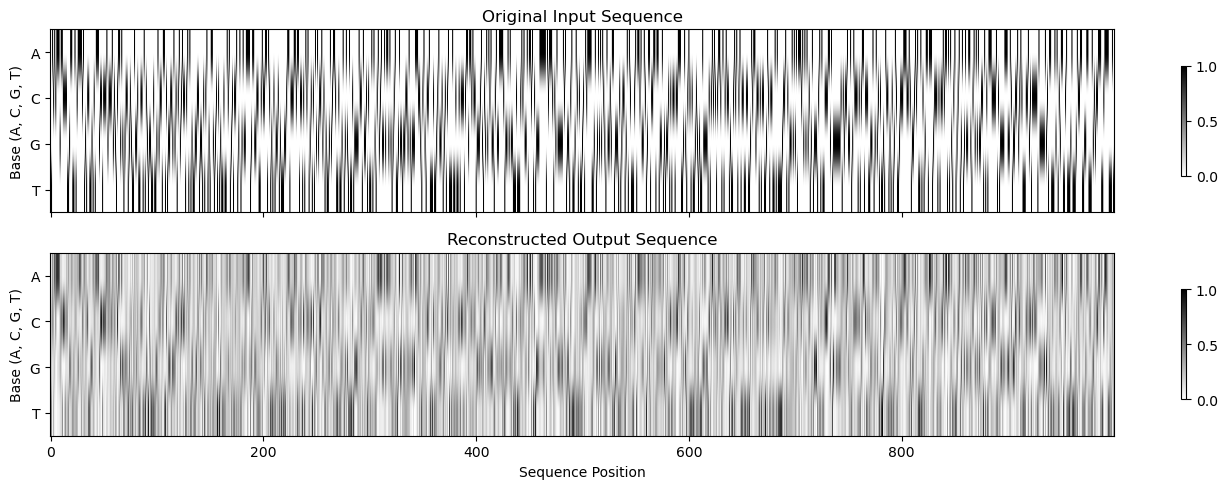

In [83]:
# Visualize the first sequence in the training set
visualize_input_vs_output(autoencoder, X_train, index=0)

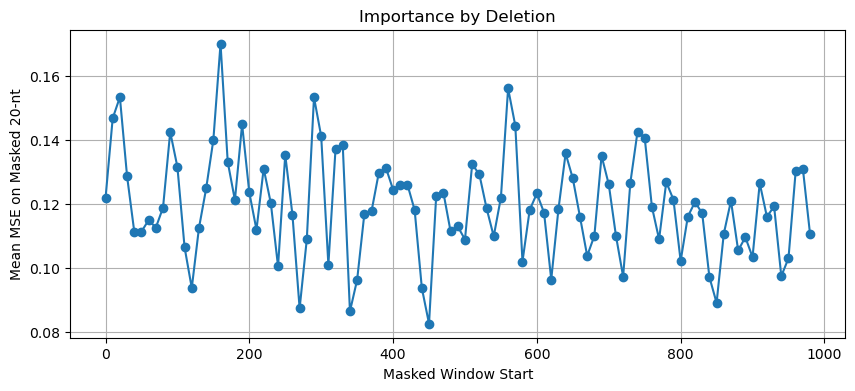

In [84]:
def delete_reconstruct_full(original_seq, model, max_len=1000, window_size=20, stride=10):
    """
    Computes reconstruction error of whole sequence after deleting a window of bases

    Parameters
    ----------
    original_seq : str
        Input RNA sequence as a string (e.g., "AUGCUA...")
    model : keras.Model
        Trained autoencoder model that takes one-hot encoded input and outputs the same shape
    max_len : int, optional
        Maximum sequence length to consider (default is 1000)
        Input will be truncated to this length
    window_size : int, optional
        Size of the window to mask, which is the number of consecutive bases (default is 20)
    stride : int, optional
        Step size for sliding the masking window (default is 10)

    Returns
    -------
    positions : np.ndarray
        Starting indices of each masked window
    errors : np.ndarray
        Reconstruction MSE at each position in the sequence for each masked window
    """
    # Truncate sequence to max_len
    seq = original_seq[:max_len]

    # ohe the unmasked full sequence once
    full_ohe = one_hot_encode(seq, max_len=max_len)
    
    positions = []
    errors = []
    
    for i in range(0, max_len - window_size + 1, stride):
        # mask: zero out the window in a copy of full_ohe
        masked = full_ohe.copy()
        masked[i:i+window_size, :] = 0
        
        # reconstruct using model
        pred = model.predict(masked[None], verbose=0)[0]  # shape (max_len,4)
        
        # compute per-position MSE
        mse = np.mean((full_ohe - pred)**2, axis=1)  # length max_len
        
        positions.append(i)
        errors.append(mse)
    
    return np.array(positions), np.stack(errors)


def plot_deletion_importance(positions, errors, stride=10, window_size=20):
    """
    Plots the average reconstruction error inside each masked window.

    Parameters
    ----------
    positions : np.ndarray
        Starting positions of each masked window from `delete_reconstruct_full()`
    errors : np.ndarray
        Per-position reconstruction MSE from `delete_reconstruct_full()`
    stride : int, optional
        Step size used during deletion (default is 10)
    window_size : int, optional
        Size of the window that was masked during each deletion step (default is 20)
    """
    
    # for each window, compute mean error *inside* the masked window
    mean_window_error = [
        e[pos:pos+window_size].mean() 
        for e, pos in zip(errors, positions)
    ]
    
    # Plot the mean errors
    plt.figure(figsize=(10,4))
    plt.plot(positions, mean_window_error, marker='o')
    plt.xlabel("Masked Window Start")
    plt.ylabel(f"Mean MSE on Masked {window_size}-nt")
    plt.title("Importance by Deletion")
    plt.grid(True)
    plt.show()

# Pick a sample sequence
seq = train_df['sequence_na'].iloc[0]

# Run deletion and reconstruction
positions, errors = delete_reconstruct_full(
    seq, autoencoder,
    max_len=1000
)

# Plot importance summary
plot_deletion_importance(positions, errors)

## Transformer

In [85]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import random
from pathlib import Path

In [86]:
# RNA vocabulary (add 'N' or IUPAC codes if needed)
TOKENS = ["[PAD]", "[MASK]", "A", "U", "G", "C"]
PAD, MASK = 0, 1
VOCAB_SIZE = len(TOKENS)
TOKEN2ID = {t: i for i, t in enumerate(TOKENS)}
ID2TOKEN = {i: t for t, i in TOKEN2ID.items()}

SEQ_LEN   = 256      # truncate / pad sequences to this length
MASK_RATE = 0.15     # % of tokens to replace with [MASK]
BATCH     = 64
EPOCHS    = 10

In [87]:
def read_fasta(file_path):
    seq, buf = [], []
    for line in Path(file_path).read_text().splitlines():
        if line.startswith(">"):
            if buf: seq.append("".join(buf)); buf = []
        else:
            buf.append(line.strip().upper().replace("T", "U"))
    if buf: seq.append("".join(buf))
    return seq

def encode_sequence(seq, seq_len=SEQ_LEN):
    ids = [TOKEN2ID.get(ch, TOKEN2ID["A"]) for ch in seq[:seq_len]]
    ids += [PAD] * (seq_len - len(ids))
    return np.array(ids, dtype=np.int32)


def mask_tokens(ids, mask_rate=MASK_RATE):
    """Return (inputs, labels) where labels have -1 for positions we ignore."""
    ids = ids.copy()
    labels = np.full_like(ids, fill_value=-1)

    # choose mask positions
    candidate = np.where((ids != PAD))[0]
    num_mask  = max(1, int(len(candidate) * mask_rate))
    mask_idx  = np.random.choice(candidate, num_mask, replace=False)

    # apply [MASK]
    labels[mask_idx] = ids[mask_idx]             # supervision signal
    ids[mask_idx]    = MASK                      # replace in input
    return ids, labels

def build_dataset(seqs, batch=BATCH, shuffle=True):
    x, y = zip(*(mask_tokens(encode_sequence(s)) for s in seqs))
    ds   = tf.data.Dataset.from_tensor_slices((np.stack(x), np.stack(y)))
    if shuffle: ds = ds.shuffle(10_000)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

In [88]:
# Convert ambigious bases to A/C/G/T equivalents
human_df_t = human_df_.copy()
human_df_t['sequence_na'] = human_df_t['sequence'].apply(replace_ambiguous_bases)

# Train/test split on the DataFrame
split_index = int(len(human_df_t) * 0.8)
X_train_ = human_df_t.iloc[:split_index]
X_test_ = human_df_t.iloc[split_index:].reset_index(drop=True)

# one hot encode the sequences, length of 400
X_train = build_dataset(X_train_['sequence_na'].tolist())
X_test = build_dataset(X_test_['sequence_na'].tolist())


# fasta_seqs = read_fasta("test.fasta")      # real data
# fasta_seqs = ["AUGGCUACGUACGUACGUA", "GCUAUGCUGAUGCUAUGCU"]  # tiny toy set
# train_ds   = build_dataset(fasta_seqs)

In [89]:
def positional_encoding(length, d_model):
    angles = np.arange(length)[:, None] / np.power(
        10000, (2 * (np.arange(d_model)[None, :] // 2)) / d_model
    )
    pos = np.zeros_like(angles)
    pos[:, 0::2] = np.sin(angles[:, 0::2])
    pos[:, 1::2] = np.cos(angles[:, 1::2])
    return tf.constant(pos, dtype=tf.float32)

def TransformerEncoder(num_layers=2, d_model=128, num_heads=4,
                       d_ff=512, rate=0.1):
    inp = layers.Input(shape=(SEQ_LEN,), dtype="int32")
    x   = layers.Embedding(VOCAB_SIZE, d_model)(inp)
    x  += positional_encoding(SEQ_LEN, d_model)

    for _ in range(num_layers):
        # Multi-head self-attention
        attn = layers.MultiHeadAttention(num_heads, key_dim=d_model)(x, x)
        x    = layers.LayerNormalization(epsilon=1e-6)(x + attn)
        # Feed-forward
        ffn  = layers.Dense(d_ff, activation="relu")(x)
        ffn  = layers.Dense(d_model)(ffn)
        x    = layers.LayerNormalization(epsilon=1e-6)(x + ffn)
        x    = layers.Dropout(rate)(x)

    logits = layers.Dense(VOCAB_SIZE)(x)          # (batch, seq_len, vocab)
    return tf.keras.Model(inp, logits)

def masked_loss(y_true, y_pred):
    mask     = tf.not_equal(y_true, -1)           # positions to train on
    y_true   = tf.boolean_mask(y_true, mask)
    y_pred   = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.sparse_categorical_crossentropy(
            y_true, y_pred, from_logits=True)

def masked_accuracy(y_true, y_pred):
    mask     = tf.not_equal(y_true, -1)
    y_true   = tf.boolean_mask(y_true, mask)
    y_pred   = tf.boolean_mask(y_pred, mask)
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [90]:
model = TransformerEncoder()
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss=masked_loss,
    metrics=[masked_accuracy])

In [91]:
history = model.fit(X_train, epochs=EPOCHS)

Epoch 1/10


2025-05-11 21:26:08.220943: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 128 bytes spill stores, 128 bytes spill loads

2025-05-11 21:26:08.653130: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53', 428 bytes spill stores, 332 bytes spill loads

2025-05-11 21:26:08.688378: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 8 bytes spill stores, 8 bytes spill loads

2025-05-11 21:26:08.716733: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_58', 100 bytes spill stores, 100 bytes spill loads

2025-05-11 21:26:08.752688: I external/local_x

113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.2297 - masked_accuracy: 0.4443

2025-05-11 21:26:22.852133: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 484 bytes spill stores, 484 bytes spill loads

2025-05-11 21:26:23.110551: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_58', 432 bytes spill stores, 432 bytes spill loads

2025-05-11 21:26:23.115393: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53', 428 bytes spill stores, 332 bytes spill loads

2025-05-11 21:26:23.152748: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 128 bytes spill stores, 128 bytes spill loads

2025-05-11 21:26:23.196174: I external/loc

114/114 ━━━━━━━━━━━━━━━━━━━━ 28s 126ms/step - loss: 1.2273 - masked_accuracy: 0.4449
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.0222 - masked_accuracy: 0.5083
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.0046 - masked_accuracy: 0.5180
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.9912 - masked_accuracy: 0.5233
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.9747 - masked_accuracy: 0.5334
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.9017 - masked_accuracy: 0.5739
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.7432 - masked_accuracy: 0.6631
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.5898 - masked_accuracy: 0.7423
Epoch 9/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.5519 - masked_accuracy: 0.7542
Epoch 10/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.5447 - masked_accuracy: 0.7548


In [143]:
def insert_mask(seq, start: int, end: int):
    number_of_char_to_replace = random.randint(1, end - start)

    for token in range(number_of_char_to_replace):
        index = random.randint(start, end)
        seq[index] = '[MASK]'

    return seq

In [ ]:
def predict_missing(seq):
    # encode + find all masks
    ids = encode_sequence(seq)
    mask_positions = np.where(ids == MASK)[0]
    if len(mask_positions) == 0:
        raise ValueError("Sequence must contain at least one [MASK] token")

    logits = model(ids[None, ...], training=False)[0]

    mask_pos_tf = tf.constant(mask_positions, dtype=tf.int32)

    mask_logits = tf.gather(logits, mask_pos_tf, axis=0)
    pred_ids   = tf.argmax(mask_logits, axis=-1).numpy()

    return [ID2TOKEN[i] for i in pred_ids]

In [144]:
def insert_mutations(seq, start: int, end: int):

    seq = insert_mask(seq, start, end)
    predictions = predict_missing(seq)

    for idx, char in enumerate(seq):
        if char == '[MASK]':
            seq[idx] = predictions[0]
            predictions.pop(0)

    return seq

In [148]:
test = 'A C T U C G A T C'.split(' ')

predictions = insert_mutations(test, 1,4)
predictions

['A', 'C', 'T', 'A', 'A', 'G', 'A', 'T', 'C']

In [95]:
test = "A G C [MASK] U [MASK] C".split(' ')
print("Predicted missing base:", predict_missing(test))

Predicted missing base: ['A', 'A']
